# Reverse Engineering the Hacker News Ranking Algorithm

This notebook is a companion to the article [Reverse Engineering the Hacker News Ranking Algorithm](http://sangaline.com/post/reverse-engineering-the-hacker-news-ranking-algorithm).
The code used to generate all of the figures in that post are included here, as is any analysis logic.
Beyond that, annotations will be fairly minimal and you will need to refer to the article for more context.
It probably makes the most sense to read the article first and then come back here if you're wondering how a specific plot was generated or if you need a starting point for doing your own analysis.

## Configuration and Settings

Settings and imports used to create a consistent plotting style

In [2]:
import os

# NOTE: images will be saved out to this directory
os.makedirs('img', exist_ok=True)

%pylab inline
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette('colorblind')
palette = sns.color_palette('colorblind')
hex_palette = sns.cubehelix_palette(as_cmap=True, rot=0.8, hue=0.7, start=2, gamma=1.2, light=0.95)

single_figsize = (6, 4)
double_figsize = (12, 4)

Populating the interactive namespace from numpy and matplotlib


## Cartoons

A couple of cartoon plots used to illustrate concepts in the introduction of the blogpost. These don't have anything to do with the analysis but I'll leave them in here for completeness' sake.

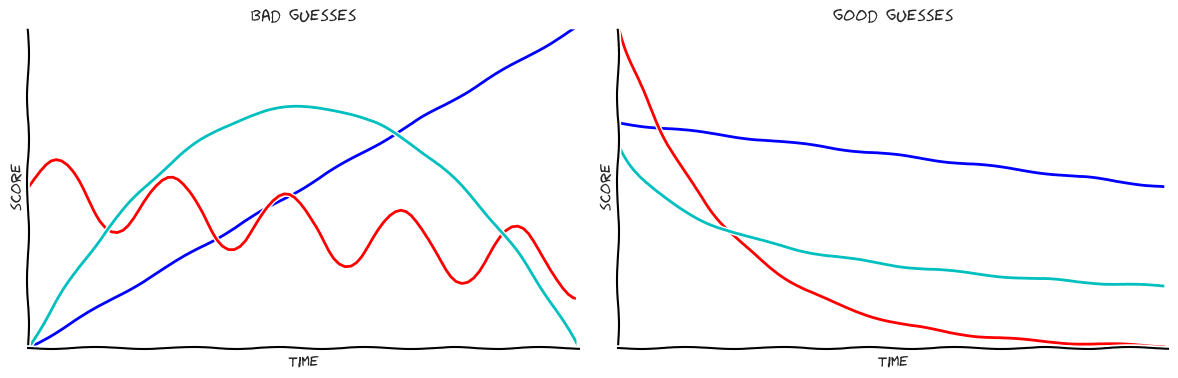

In [3]:
# make it clear that the graphs are qualitative
with plt.xkcd():
    # set up the split figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=double_figsize)
    for ax in [ax1, ax2]:
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('time')
        ax.set_ylabel('score')
        ax.set_ylim(0, 1)

    x = np.linspace(0, 1, 100)

    # plot a few functions that violate are constraints
    ax1.plot(x, x)
    ax1.plot(x, 0.5 - 0.25*x + 0.1*np.sin(x*30))
    ax1.plot(x, -3*x*(x-1))
    ax1.set_title('bad guesses')

    # and a few that don't
    ax2.plot(x, 0.7 - x*.2)
    ax2.plot(x, np.exp(-5*x))
    ax2.plot(x, 0.2/np.power(0.1 + x, 0.5))
    ax2.set_title('good guesses')

    fig.tight_layout()
    fig.savefig('img/guesses.png')
    plt.show()

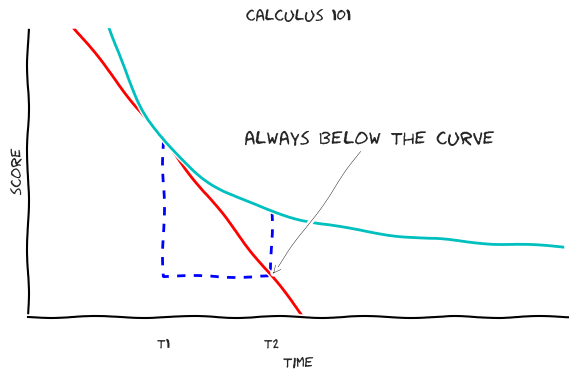

In [4]:
with plt.xkcd():
    fig = plt.figure(figsize=single_figsize)
    ax = fig.add_subplot(1, 1, 1)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('calculus 101')
    ax.set_xlabel('time')
    ax.set_ylabel('score')
    ax.set_ylim(0, 1)

    # the f(x) function
    f = lambda x: 0.2 + 0.05/np.power(0.1 + x, 2)

    # the tangent line
    tangent_x = 0.25
    tangent_y = f(tangent_x)
    delta_x = 10**-5
    m = (f(tangent_x + delta_x) - f(tangent_x))/(delta_x)
    b = tangent_y - m*tangent_x
    x = np.linspace(0, 1, 100)

    # the dotted lines for the deltas
    box_width = 0.2
    box_height = -m*box_width
    box_x = (tangent_x, tangent_x, tangent_x + box_width, tangent_x + box_width)
    box_y = (tangent_y, tangent_y - box_height, tangent_y - box_height,
             tangent_y - (f(tangent_x) - f(tangent_x + box_width)))

    # the plotting order is chosen for pretty overlay order
    plt.plot(box_x, box_y, ls='--')
    ax.plot(x, m*x + b)
    ax.plot(x, f(x))

    ax.set_xticks([tangent_x, tangent_x + box_width])
    ax.set_xticklabels(['t1', 't2'])
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(bottom=False)

    # the annotations
    padding = 0.02
    ax.annotate('always below the curve',
        xy=(box_x[-1], box_y[-2]), arrowprops=dict(arrowstyle='->'), xytext=(0.4, 0.6))

    fig.tight_layout()
    fig.savefig('img/calculus-101.png')
    plt.show()

## Data Processing

Load in the data from file and compute the bounds.

In [5]:
import gzip, calendar

def load_data(filename='front-page-snapshots.dat.gz'):
    with gzip.open(filename, 'r') as f:
        for line in f:
            yield eval(line)

def calculate_bounds(data = None, f_Df = None, g_Dg = lambda v: v, start_time=None, end_time=None):
    upper_x, upper_y, lower_x, lower_y, lower_timestamps, upper_timestamps = [], [], [], [], [], []
    start_timestamp = calendar.timegm(start_time.timetuple()) if start_time else None
    end_timestamp = calendar.timegm(end_time.timetuple()) if end_time else None
    for timestamp, stories in (data or load_data()):
        if (start_timestamp and timestamp < start_timestamp) or (end_timestamp and timestamp > end_timestamp):
            continue
            
        for i, (id1, t1, v1) in enumerate(stories):
            for id2, t2, v2 in stories[i + 1:]:
                if v1 == v2 or t1 == t2:
                    continue

                if not f_Df:
                    # if f is undefined limit is for -f/f'
                    x = t1
                    y = ((t2 - t1)/(v2 - v1))*g_Dg(v2)
                    bound_type = 'upper' if v1 > v2 else 'lower'
                    if v1 < v2:
                        upper_x.append(x)
                        upper_y.append(y)
                        upper_timestamps.append(timestamp)
                    else:
                        lower_x.append(x)
                        lower_y.append(y)
                        lower_timestamps.append(timestamp)
                else:
                    # otherwise it is for g/g`
                    x = v2
                    y = -((v2 - v1)/(t2 - t1))*f_Df(t1)
                    if t1 > t2:
                        upper_x.append(x)
                        upper_y.append(y)
                        upper_timestamps.append(timestamp)
                    else:
                        lower_x.append(x)
                        lower_y.append(y)
                        lower_timestamps.append(timestamp)
    return np.array(lower_x), np.array(lower_y), np.array(upper_x), np.array(upper_y), \
            np.array(lower_timestamps), np.array(upper_timestamps)

## Time Dependence

We start off by taking a look at how well $\tau$ is constrained for a single $t$ slice over time.
Each slice is normalized and then plotted using a log color scale for the scaled number of violations.
We can see a clear rise in the preferred value of $\tau$ around the start of 2009 and then the amount of violations skyrocket around mid 2014 (which is roughly what we would expect if major vote fuzzing were added).
It looks like there might also be some changes in mid 2011 but it's hard to tell from this plot whether or not that's just caused by noise.

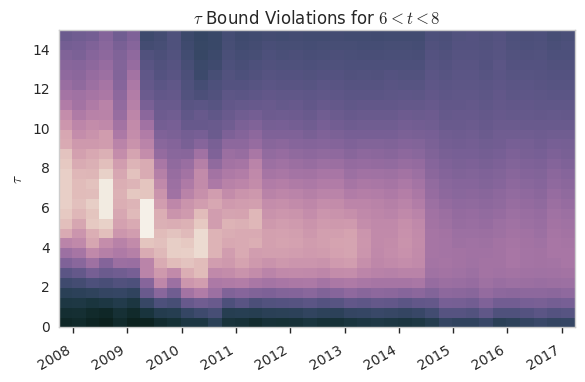

In [6]:
import datetime as dt
import calendar
from dateutil import relativedelta
import matplotlib.dates as mdates

# settings
minimum_t, maximum_t = 6, 8
tau_range = (0, 15)
tau_bins = 30
date_range = (dt.datetime(2007, 10, 1), dt.datetime(2017, 4, 1))
grouped_months = 3
assert 12/grouped_months == 12//grouped_months

# load the data
try:
    data
except:
    data = list(load_data())
lower_t, lower_tau, upper_t, upper_tau, lower_timestamps, upper_timestamps = calculate_bounds(data)

# filter to the allowed t range
lower_matches = np.logical_and(lower_t > minimum_t, lower_t < maximum_t)
lower_tau, lower_timestamps = lower_tau[lower_matches], lower_timestamps[lower_matches]
upper_matches = np.logical_and(upper_t > minimum_t, upper_t < maximum_t)
upper_tau, upper_timestamps = upper_tau[upper_matches], upper_timestamps[upper_matches]


# calculate the ranges
timestamp_range = (calendar.timegm(date_range[0].timetuple()),
                   calendar.timegm(date_range[1].timetuple()))
delta = relativedelta.relativedelta(date_range[1], date_range[0])
timestamp_bins = (delta.years*12 + delta.months)/grouped_months

# build the histogram
H_lower, x_edges, y_edges = np.histogram2d(lower_timestamps, lower_tau,
    range=(timestamp_range, tau_range), bins=(timestamp_bins, tau_bins))
H_lower = H_lower.transpose()
H_upper, x_edges, y_edges = np.histogram2d(upper_timestamps, upper_tau,
    range=(timestamp_range, tau_range), bins=(timestamp_bins, tau_bins))
H_upper = H_upper.transpose()
H_violations = np.cumsum(H_upper, axis=0) + np.cumsum(H_lower[::-1], axis=0)[::-1]
column_sums = H_violations.sum(axis=0)
H_violations = H_violations / column_sums[np.newaxis, :]
imdata = np.ma.masked_invalid(np.atleast_2d(H_violations))

# build the grid using dates
x_dates = mdates.drange(date_range[0], date_range[1], datetime.timedelta(grouped_months*365.1/12))
X, Y = np.meshgrid(x_dates, y_edges)

fig = plt.figure(figsize=single_figsize)
ax = fig.add_subplot(1, 1, 1)
ax.pcolormesh(X, Y, imdata, norm=mpl.colors.LogNorm(), cmap=hex_palette);
#fig.colorbar(ax)

# x/date axis
ax.set_xlim(date_range[0], date_range[1])
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_tick_params(direction='out', width=1, length=4)
ax.xaxis.tick_bottom()
ax.xaxis_date()
fig.autofmt_xdate()

ax.set_ylabel(r'$\tau$')
ax.set_ylim(y_edges[0], y_edges[-1])

ax.set_title(r'$\tau$ Bound Violations for $ %d < t < %d $' % (minimum_t, maximum_t))
plt.tight_layout()
plt.savefig('img/bound-violations-over-time.png')
plt.show()

## Analysis Methods

This is sort of the "meat" of the analysis.
Here we define functions that allow us to find linear fits that minimize the total number of violations and to estimate errors on those fits through the use of statistical bootstrapping.

In [7]:
from scipy.optimize import minimize
from scipy.interpolate import interp2d

# create histograms for the upper and lower bounds as a function of t or v
def limit_histograms(lower_x, lower_y, upper_x, upper_y, bins=(30,30), range=((0,15), (0,15)),
                     x_label='t', y_label=r'$\tau$', filename=None, plot=True):
    H_lower, x_edges, y_edges = np.histogram2d(lower_x, lower_y, bins=bins, range=range)
    H_upper, x_edges, y_edges = np.histogram2d(upper_x, upper_y, bins=bins, range=range)
    H_lower, H_upper = H_lower.transpose(), H_upper.transpose()
    extent = [y_edges[0], y_edges[-1], x_edges[0], x_edges[-1]]
    X, Y = np.meshgrid(x_edges, y_edges)

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=double_figsize)

        mesh1 = ax1.pcolormesh(X, Y, H_upper, norm=mpl.colors.LogNorm(), cmap=hex_palette)
        fig.colorbar(mesh1, ax=ax1)
        ax1.set_title('Upper Bounds')

        mesh2 = ax2.pcolormesh(X, Y, H_lower, norm=mpl.colors.LogNorm(), cmap=hex_palette)
        fig.colorbar(mesh2, ax=ax2)
        ax2.set_title('Lower Bounds')

        for ax in (ax1, ax2):
            ax.set_xlim(x_edges[0], x_edges[-1])
            ax.set_ylim(y_edges[0], y_edges[-1])
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)

        plt.tight_layout()
        if filename:
            plt.savefig(filename)
        plt.show()
    return H_lower, H_upper, x_edges, y_edges
    
# find the best fit for a given total violation matrix
def minimize_violations(H, x_edges, y_edges, f, guess):
    # interpolate the histogram so derivatives behave
    H_approximation = interp2d((x_edges[1:] + x_edges[:-1])/2, (y_edges[1:] + y_edges[:-1])/2, H)
    x = (y_edges[1:] + y_edges[:-1])/2
    def total_violations(p):
        y = f(x, p)
        violations = np.sum([H_approximation(x0, y0) for x0, y0 in zip(x, y)])
        return violations
    result = minimize(total_violations, guess, method='Nelder-Mead', options={ 'maxiter': 10**4 })
    if not result.success:
        print('WARNING: fit failed, see details below...')
        print(result)
    return result.x, lambda x: f(x, result.x)

# bootstrap a new random matrix from a measured one
def random_matrix(H, poisson=True):
    indices = np.arange(H.shape[0]*H.shape[1])
    p = H.flatten()
    total = np.sum(p)
    new_total = np.random.poisson(total) if poisson else total
    p = p/total
    add_indices = np.random.choice(indices, p=p, size=new_total)
    counts = np.zeros(p.shape)
    np.add.at(counts, add_indices, 1)
    return np.reshape(counts, H.shape)
        
# combine the upper and lower histograms and do the bootstrapping and fitting
def combined_limits(H_lower, H_upper, x_edges, y_edges, fit_function=lambda x, p: p[0] + p[1]*x, fit_guess=[0,1],
                     x_label='t', y_label=r'$\tau$', filename=None, plot = True, bootstraps=100):
    H_upper_cumulative = np.cumsum(H_upper, axis=0)
    H_lower_cumulative = np.cumsum(H_lower[::-1], axis=0)[::-1]
    H = H_lower_cumulative + H_upper_cumulative
    X, Y = np.meshgrid(x_edges, y_edges)
    
    if plot:
        fig = plt.figure(figsize=single_figsize)
        ax = fig.add_subplot(1, 1, 1)

        # the histogram of violations
        mesh = ax.pcolormesh(X, Y, H, norm=mpl.colors.LogNorm(), cmap=hex_palette)
        ax.set_xlim(x_edges[0], x_edges[-1])
        ax.set_ylim(y_edges[0], y_edges[-1])
        ax.set_title('Total Violations')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        fig.colorbar(mesh, ax=ax)
    
    if fit_function and fit_guess:
        # a linear fit
        best_parameters, fit = minimize_violations(H, x_edges, y_edges, f=fit_function, guess=fit_guess)
        if plot:
            plt.plot(x_edges, fit(x_edges), lw=3, color=palette[5])

        # estimate the errors by bootstrapping
        parameters_tiled = np.zeros((bootstraps, len(best_parameters)))
        y_tiled = np.zeros((bootstraps, len(x_edges)))
        for i in range(bootstraps):
            H_upper_cumulative = np.cumsum(random_matrix(H_upper), axis=0)
            H_lower_cumulative = np.cumsum(random_matrix(H_lower[::-1]), axis=0)[::-1]
            H = H_lower_cumulative + H_upper_cumulative
            parameters, fit = minimize_violations(H, x_edges, y_edges, f=fit_function, guess=best_parameters)

            parameters_tiled[i,:] = parameters
            y_tiled[i,:] = fit(x_edges)

        y_std = np.std(y_tiled, axis=0, ddof=1)
        y_mean = np.mean(y_tiled, axis=0)
    
    if plot:
        # the minimum values for each bin
        x = (x_edges[1:] + x_edges[:-1])/2
        minimum_bins = (np.argmin(H, 0) + (len(y_edges) -1 - np.argmin(H[::-1], 0)))//2
        y = (y_edges[minimum_bins] + y_edges[minimum_bins + 1])/2
        plt.plot(x, y, 'o', color=palette[2], ms=5)

        plt.tight_layout()
        if filename:
            plt.savefig(filename)
        plt.show()
    
    if fit_function and fit_guess:
        return best_parameters, np.std(parameters_tiled, axis=0, ddof=1)

And now a helper function that performs the steps necessary to analyze a specific time period.

In [8]:
def analyze_epoch(start_time=dt.date(2007, 1, 1), end_time = dt.date(2009, 1, 1), tau_bins=(58, 30),
                  tau_range=((0.5, 15), (0, 15)), nu_bins=(29, 100), nu_range=((1.5, 30), (0,45)), suffix=''):
    print('Analyzing', start_time, 'through', end_time)
    # tau analysis
    lower_t, lower_tau, upper_t, upper_tau, lower_timestamps, upper_timestamps = \
        calculate_bounds(data, end_time=end_time)
    H_lower, H_upper, x_edges, y_edges = limit_histograms(lower_t, lower_tau, upper_t, upper_tau,
        bins=tau_bins, range=tau_range, filename='img/tau-limits-%s' % suffix)
    tau_parameters, tau_parameter_errors = combined_limits(H_lower, H_upper, x_edges, y_edges,
        filename='img/tau-fit-%s.png' % suffix)
    print('\ttau_0:', tau_parameters[0], '+/-', tau_parameter_errors[0])
    print('\ttau_1:', tau_parameters[1], '+/-', tau_parameter_errors[1])

    # nu analysis (using the fit parameters from tau)
    f_Df = lambda t: -(tau_parameters[0] + tau_parameters[1]*t)
    lower_v, lower_nu, upper_v, upper_nu, lower_timestamps, upper_timestamps = \
        calculate_bounds(data, end_time=end_time, f_Df=f_Df)
    H_lower, H_upper, x_edges, y_edges = limit_histograms(lower_v, lower_nu, upper_v, upper_nu, bins=nu_bins,
        range=nu_range, x_label='v', y_label=r'$\nu$', filename='img/nu-limits-%s.png' % suffix)
    nu_parameters, nu_parameter_errors = combined_limits(H_lower, H_upper, x_edges, y_edges, 
        x_label='v', y_label=r'$\nu$', filename='img/nu-fit-%s.png' % suffix)
    print('\tnu_0:', nu_parameters[0], '+/-', nu_parameter_errors[0])
    print('\tnu_1:', nu_parameters[1], '+/-', nu_parameter_errors[1])

## Main Analysis Results

Now we go through and analyze each epoch.

Analyzing 2007-01-01 through 2009-01-01


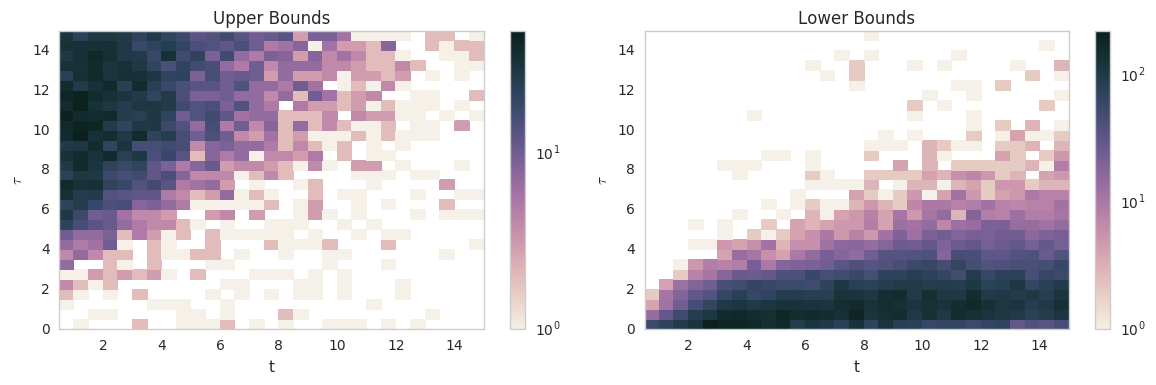

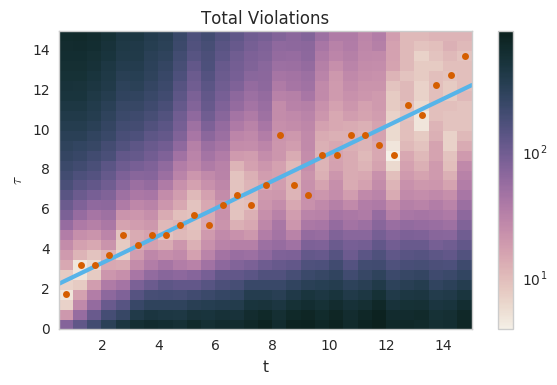

	tau_0: 1.95309592551 +/- 0.159609779641
	tau_1: 0.687503939938 +/- 0.0332459138739


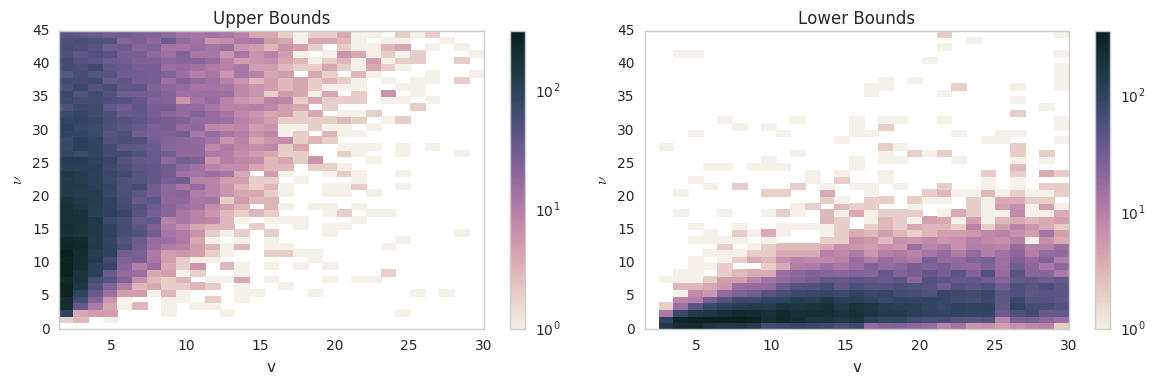

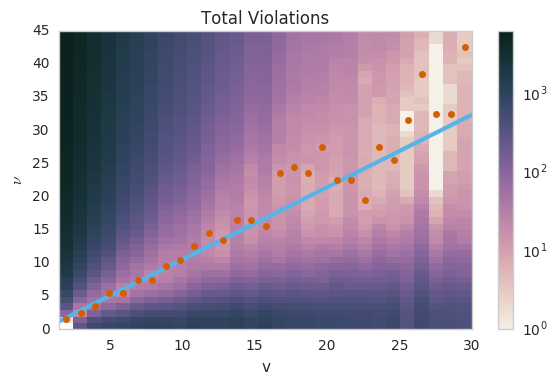

	nu_0: -0.409078046663 +/- 0.314216454235
	nu_1: 1.09091138856 +/- 0.069423432527


In [9]:
analyze_epoch(tau_bins=(29, 30), nu_bins=(29, 45), suffix='2007-2009')

Analyzing 2009-04-01 through 2014-07-01


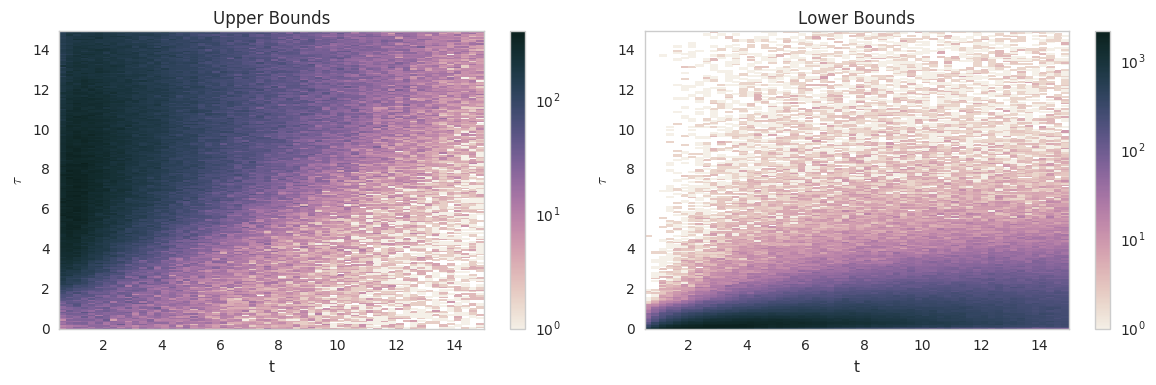

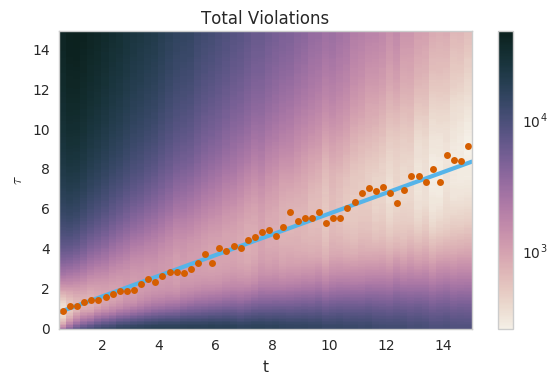

	tau_0: 0.605335521708 +/- 0.0174241035901
	tau_1: 0.521041438053 +/- 0.00857186153466


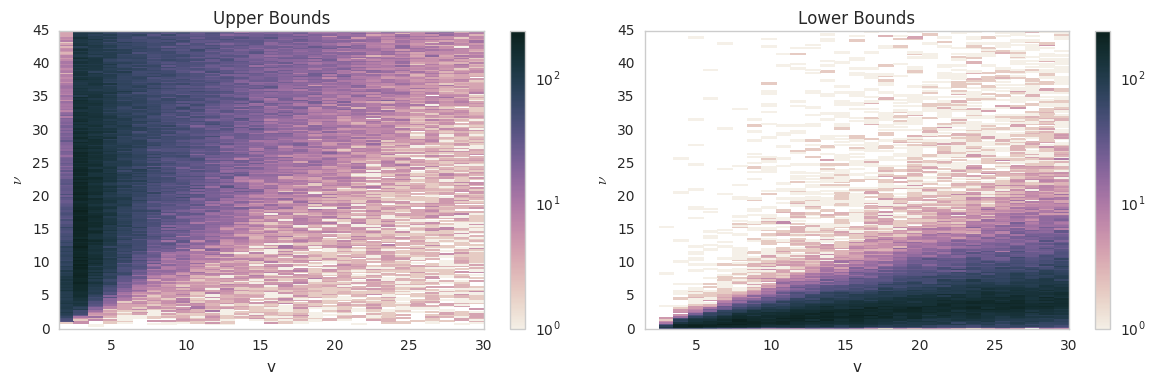

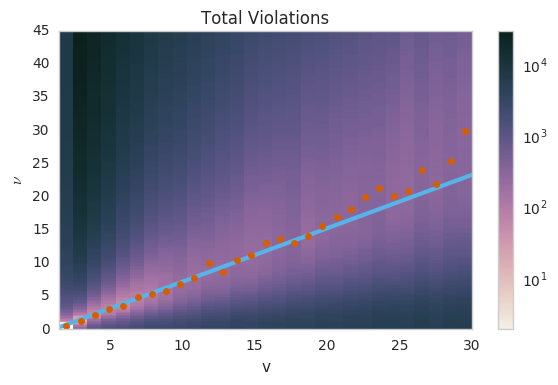

	nu_0: -0.888460138711 +/- 0.0762473319372
	nu_1: 0.805347056563 +/- 0.0158643995946


In [10]:
analyze_epoch(start_time=dt.date(2009, 4, 1), end_time = dt.date(2014, 7, 1), 
    tau_bins=(58, 200), nu_bins=(29, 200), suffix='2009-2014')

Analyzing 2014-07-01 through None


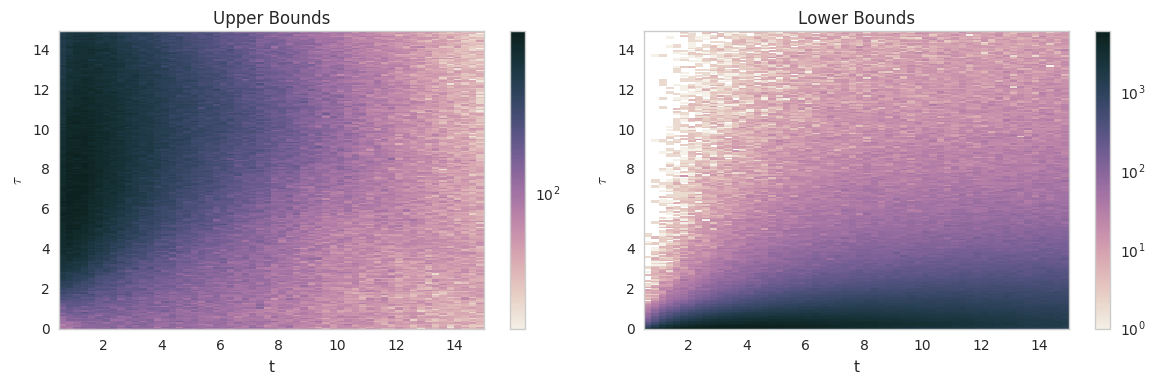

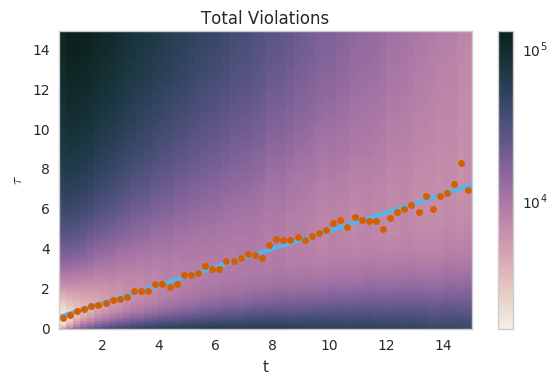

	tau_0: 0.395389028443 +/- 0.0101886540049
	tau_1: 0.456249741707 +/- 0.00395182938533


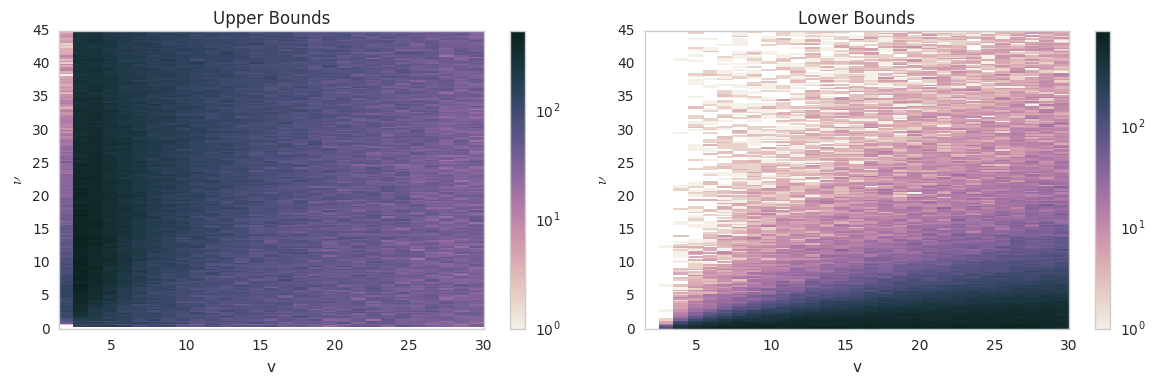

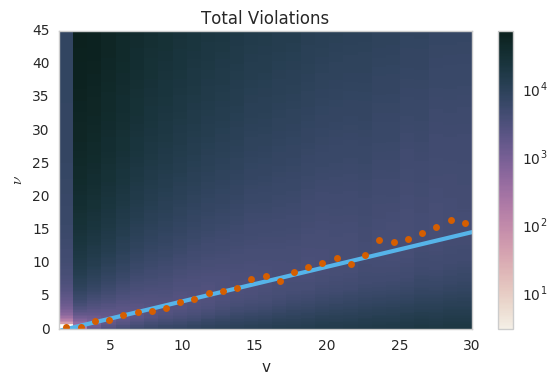

	nu_0: -0.999333043137 +/- 0.0536468500026
	nu_1: 0.521276481676 +/- 0.00767089292558


In [11]:
analyze_epoch(start_time=dt.date(2014, 7, 1), end_time = None, 
    tau_bins=(58, 200), nu_bins=(29, 200), suffix='2014-2017')

## Minimizing Global Cost Functions

Just for kicks, let's go back through the data for each of these epochs and see what values fit best for $\tau_0$ and $\tau_1$.
We'll use both the Levenshtein distance and the Euclidean distance between the observed order of stories on the front page and the predicted order given the power law score function.

In [12]:
import editdistance
from scipy.optimize import differential_evolution

def levenshtein_distance(original_order, sorted_order):
    return editdistance.eval(original_order, sorted_order)

def euclidean_distance(original_order, sorted_order):
    return np.sum(np.power(original_order - sorted_order, 2))

def build_global_cost_function(data=None, distance_function=levenshtein_distance, start_time=None, end_time=None):
    start_timestamp = calendar.timegm(start_time.timetuple()) if start_time else None
    end_timestamp = calendar.timegm(end_time.timetuple()) if end_time else None
    
    filtered_data = []
    for timestamp, stories in (data or load_data()):
        if (start_timestamp and timestamp < start_timestamp) or (end_timestamp and timestamp > end_timestamp):
            continue
        filtered_data.append(stories)
        
    def global_cost_function(tau):
        def score(t, v):
            return v/np.power(tau[0] + t, 1/tau[1])
        
        distance = 0
        for stories in filtered_data:
            original_order = list(range(len(stories)))
            sorted_order = sorted(original_order, key=lambda i: -score(stories[i][1], stories[i][2]))
            distance += distance_function(np.array(original_order), np.array(sorted_order))
        return distance
    return global_cost_function

def globally_minimize_epoch(start_time=dt.date(2007, 1, 1), end_time = dt.date(2009, 1, 1)):
    print('Analyzing', start_time, 'through', end_time, '\n')
    time_args = { 'start_time': start_time, 'end_time': end_time }
    
    euclidean_cost_function = build_global_cost_function(distance_function=euclidean_distance, **time_args)
    result = differential_evolution(euclidean_cost_function, [(0,5), (0.1, 1.5)])
    print('\tEuclidean Distance Measure')
    print('\t\ttau_0:', result.x[0])
    print('\t\ttau_1:', result.x[1], '\n')
    
    levenshtein_cost_function = build_global_cost_function(distance_function=levenshtein_distance, **time_args)
    result = differential_evolution(levenshtein_cost_function, [(0,5), (0.1, 1.5)])
    print('\tLevenshtein Distance Measure')
    print('\t\ttau_0:', result.x[0])
    print('\t\ttau_1:', result.x[1], '\n')

In [13]:
globally_minimize_epoch(start_time=dt.date(2007, 1, 1), end_time = dt.date(2009, 1, 1))
globally_minimize_epoch(start_time=dt.date(2009, 4, 1), end_time = dt.date(2014, 7, 1))
globally_minimize_epoch(start_time=dt.date(2014, 7, 1), end_time = dt.datetime.now())

Analyzing 2007-01-01 through 2009-01-01

	Euclidean Distance Measure
		tau_0: 3.14655402886
		tau_1: 0.668953497782 

	Levenshtein Distance Measure
		tau_0: 3.34011954531
		tau_1: 0.644430468091

Analyzing 2009-04-01 through 2014-07-01

	Euclidean Distance Measure
		tau_0: 2.21924949742
		tau_1: 0.442884619029 

	Levenshtein Distance Measure
		tau_0: 2.32262602794
		tau_1: 0.434945109904
Analyzing 2014-07-01 through 2017-03-09 11:42:25.284115

	Euclidean Distance Measure
		tau_0: 4.63041999544
		tau_1: 0.289853131899 

	Levenshtein Distance Measure
		tau_0: 2.17241827542
		tau_1: 0.416670352028


# Score Function Visualization

We'll just generate a few plots of the various score functions.
I probably should have stored these numbers globally but it's also convenient to run this section without waiting for the slow global optimization to finish.

2007/01/01 - 2008/12/31


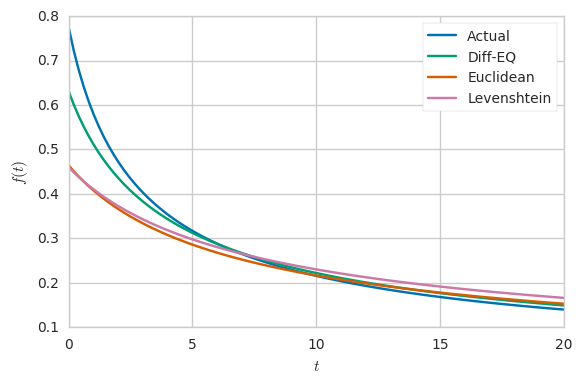

2009/04/01 - 2014/06/31


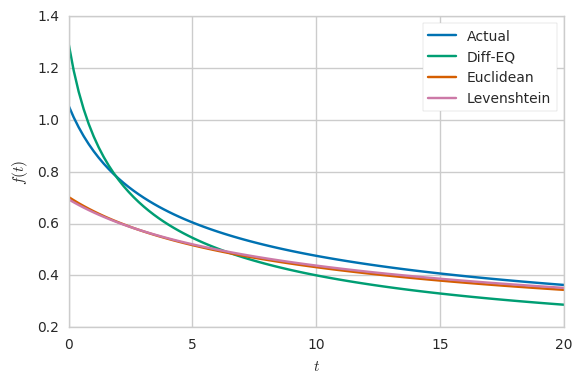

2014/07/01 - 2017/


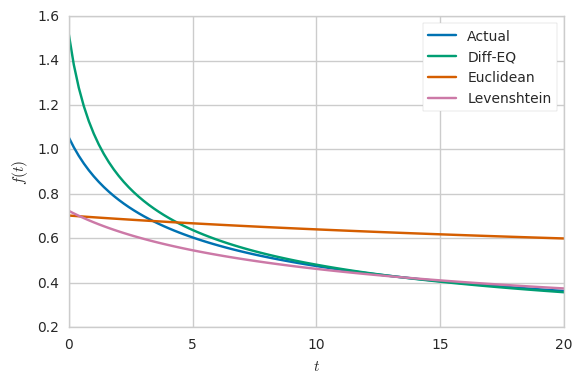

In [14]:
def f(t, v, tau_0, tau_1):
    return v / (tau_0 + tau_1*t)**tau_1

t = np.linspace(0, 20, 100)
v = 1

fig = plt.figure(figsize=single_figsize)
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, f(t, v, 1.43, 0.714), label='Actual')
ax.plot(t, f(t, v, 1.95, 0.69), label='Diff-EQ')
ax.plot(t, f(t, v, 3.15, 0.669), label='Euclidean')
ax.plot(t, f(t, v, 3.34, 0.644), label='Levenshtein')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$f(t)$')
print('2007/01/01 - 2008/12/31')
ax.legend(frameon=True)
fig.tight_layout()
fig.savefig('img/f-parameterizations-2007-2009.png')
plt.show()

fig = plt.figure(figsize=single_figsize)
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, f(t, v, 0.888, 0.444), label='Actual')
ax.plot(t, f(t, v, 0.61, 0.52), label='Diff-EQ')
ax.plot(t, f(t, v, 2.22, 0.443), label='Euclidean')
ax.plot(t, f(t, v, 2.32, 0.435), label='Levenshtein')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$f(t)$')
print('2009/04/01 - 2014/06/31')
ax.legend(frameon=True)
fig.tight_layout()
fig.savefig('img/f-parameterizations-2009-2014.png')
plt.show()

fig = plt.figure(figsize=single_figsize)
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, f(t, v, 0.888, 0.444), label='Actual')
ax.plot(t, f(t, v, 0.40, 0.456), label='Diff-EQ')
ax.plot(t, f(t, v, 4.63, 0.23), label='Euclidean')
ax.plot(t, f(t, v, 2.17, 0.417), label='Levenshtein')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$f(t)$')
print('2014/07/01 - 2017/')
ax.legend(frameon=True)
fig.tight_layout()
fig.savefig('img/f-parameterizations-2014-2017.png')
plt.show()

## Promoted Stories

Now let's go through and find the stories that would need the biggest adjustment factor in order to get where the were on the front page.
We'll take a simple approach of considering only stories in the top position and then dividing the average score of everything else on the page by the top story's score.
This should give something very roughly like a minimum bound on the enhancement factor that would need to be applied to the top story.

There are some issues here where the times in the Hacker News database seem wrong and unfortunately these dominate the most apparently promoted stories.
For example, this [archive.org snapshot](http://web.archive.org/web/20151225193258/https://news.ycombinator.com/) shows the top story "Game Theory: An open-access textbook with solved exercises" as having an age of 3 hours but according to the Hacker News API the age would have been 53 hours.
It's not clear exactly what the mechanism is here.

I'm going to leave this code though because the example of how to interface with Firebase to fetch story details might be useful to anybody who wants to analyze things further.
I would be very curious to see a resolution to the ages not matching up.

In [15]:
from firebase import firebase
hn_application = firebase.FirebaseApplication('https://hacker-news.firebaseio.com/', None)

def find_enhancements(data=None, start_time=None, end_time=None, tau_0=0.888, tau_1=0.444):
    start_timestamp = calendar.timegm(start_time.timetuple()) if start_time else None
    end_timestamp = calendar.timegm(end_time.timetuple()) if end_time else None
    
    def score_function(story):
        return story[2]/np.power(tau_0 + story[1], 1/tau_1)
    
    enhancements = []
    for timestamp, stories in (data or load_data()):
        if (start_timestamp and timestamp < start_timestamp) or (end_timestamp and timestamp > end_timestamp):
            continue
        scores = list(map(score_function, stories))
        enhancement_factor = np.mean(scores[1:])/scores[0]
        if not np.isnan(enhancement_factor):
            enhancements.append((stories[0], enhancement_factor))
        
    enhancements.sort(key=lambda x: x[1])
    return enhancements

def get_story_details(id):
    return hn_application.get('/v0/item/' + str(id), None)

In [16]:
enhancements = find_enhancements(start_time=dt.date(2014, 7, 1))

for (id, age, votes), enhancement_factor in enhancements[-20:]:
    story = get_story_details(id)
    print(story['title'])
    print('\tAge:', age)
    print('\tVotes:', votes)
    print('\tEnhancement Factor:', enhancement_factor, '\n')

Game Theory: An open-access textbook with solved exercises
	Age: 52.74916666666667
	Votes: 61
	Enhancement Factor: 54.4548097796 

Annotation is now a web standard
	Age: 43.57833333333333
	Votes: 144
	Enhancement Factor: 57.9803445174 

Annotation is now a web standard
	Age: 43.569722222222225
	Votes: 144
	Enhancement Factor: 58.2726703035 

Annotation is now a web standard
	Age: 43.507777777777775
	Votes: 140
	Enhancement Factor: 60.9967775886 

Why the Tor attack matters
	Age: 46.47222222222222
	Votes: 124
	Enhancement Factor: 62.7486901224 

Why the Tor attack matters
	Age: 46.46333333333333
	Votes: 124
	Enhancement Factor: 63.0642998707 

Anguish: Invisible Programming Language and Invisible Data Theft
	Age: 41.473333333333336
	Votes: 95
	Enhancement Factor: 64.0714743563 

Anguish: Invisible Programming Language and Invisible Data Theft
	Age: 41.463055555555556
	Votes: 95
	Enhancement Factor: 64.3797284623 

Diff So Fancy: make Git diffs look good
	Age: 32.37222222222222
	Votes: 5